# Path Integral Molecular Dynamics Analysis of Water

**Author:** Ouail Zakary  
**ORCID:** [0000-0002-7793-3306](https://orcid.org/0000-0002-7793-3306)  
**E-mail:** [Ouail.Zakary@oulu.fi](mailto:Ouail.Zakary@oulu.fi)  
**Website:** [Ouail Zakary - webpage](https://cc.oulu.fi/~nmrwww/members/Ouail_Zakary.html)

---

This notebook provides analysis of Path Integral Molecular Dynamics (PIMD) simulations for a water molecule using `i-PI` with `LAMMPS` as the force engine. We implement the `q-TIP4P/f` water model to explore quantum nuclear effects and their influence on molecular properties.

### Quantum Effects in Molecular Systems

The Born-Oppenheimer approximation separates the joint quantum mechanical problem for electrons and nuclei into two independent problems. While it's common to treat nuclei as classical particles, this approximation can introduce significant errors, particularly for systems containing light atoms like hydrogen.

### Path Integral Formalism

To capture nuclear quantum effects, we use the path integral formalism, which maps the quantum partition function onto a classical system of ring polymers:

- Each quantum particle is represented by P classical replicas ("beads")
- Adjacent beads are connected by temperature-dependent harmonic springs
- The spring frequency ω = P/(βℏ) determines the quantum character
- The formalism exactly reproduces quantum statistics at the P → ∞ limit

The textbook by [Tuckerman](https://global.oup.com/academic/product/statistical-mechanics-theory-and-molecular-simulation-9780198825562?cc=fi&lang=en&) contains a pedagogic introduction to the topic, while this [paper](https://pubs.aip.org/aip/jcp/article/133/12/124104/955703/Efficient-stochastic-thermostatting-of-path) outlines the implementation used in i-PI.



### Ring-Polymer Representation

<img src="./pimd-slices-round.png" width="600" alt="Graphical Abstract">

Schematic representation of the ring-polymer Hamiltonian for a water molecule

### Analysis Overview

In this notebook, we will:
1. Process PIMD trajectory data from i-PI
2. Analyze quantum delocalization through radius of gyration
3. Study bond length and angle distributions
4. Visualize ring polymer configurations

### Required Packages:
```bash
pip install numpy matplotlib pandas scipy plotly
```

---

# Analysis Setup

For this PIMD analysis, we'll use several Python packages:
- `numpy`: For numerical computations and array operations
- `pandas`: For data manipulation and analysis
- `plotly`: For creating interactive plots
- `scipy`: For scientific computations and distance calculations
- `glob`: For finding trajectory files

The plotting configuration is set up to create:
1. Regular 2D plots (600x600 pixels)
2. 3D plots (500x500 pixels)

All plots will have:
- Interactive features (zoom, pan, hover information)
- Clear grid lines
- Professional formatting
- Consistent styling

Run the following cell to import the necessary packages and set up the plotting environment.

In [8]:
# Import required packages
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.spatial.distance import pdist, squareform
import glob
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt

# Initialize plotly for notebook
init_notebook_mode(connected=True)

# Set default plot layout
plotly_layout = dict(
    width=600,
    height=600,
    font=dict(size=12),
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    plot_bgcolor='white',
    hovermode='closest'
)

# Set 3D plot layout
plotly_layout_3d = plotly_layout.copy()
plotly_layout_3d.update(width=500, height=500)

print("Analysis environment ready!")
print(f"Plot dimensions: {plotly_layout['width']}x{plotly_layout['height']} pixels (2D), "
      f"{plotly_layout_3d['width']}x{plotly_layout_3d['height']} pixels (3D)")

Analysis environment ready!
Plot dimensions: 600x600 pixels (2D), 500x500 pixels (3D)


## 1. Reading Simulation Data

In Path Integral Molecular Dynamics (PIMD), the quantum nature of nuclei is represented through the ring polymer formalism. Each atom is represented by multiple copies (beads) of itself, connected by harmonic springs to form a ring polymer.

We need to:
1. Read the trajectory files for each bead (stored as .xyz files)
2. Extract atomic positions from each frame
3. Organize the data for analysis

The trajectory files are named `simulation.pos_*.xyz`, where * represents the bead index (0 to N-1).

### XYZ File Format:
```
3           # Number of atoms
comment     # Comment line
O  x y z    # Atom type and coordinates
H  x y z
H  x y z
```

Run the following cell to load the trajectory data for all beads.

In [9]:
def read_xyz(filename):
    """Read XYZ trajectory file and extract atomic positions
    
    Returns:
        numpy.ndarray: Array of shape (n_frames, n_atoms, 3) containing positions
    """
    positions = []
    with open(filename, 'r') as f:
        while True:
            try:
                # Read number of atoms and skip comment line
                n_atoms = int(f.readline())
                f.readline()
                
                # Read atomic positions (skip atom type in column 0)
                frame = []
                for _ in range(n_atoms):
                    line = f.readline().split()
                    frame.append([float(x) for x in line[1:4]])
                positions.append(frame)
            except:
                break
    return np.array(positions)

# Read trajectory files for all beads
bead_files = sorted(glob.glob('./pimd_run_1/simulation.pos_*.xyz'))
trajectories = [read_xyz(f) for f in bead_files]
n_beads = len(trajectories)

# Print summary
print(f"Found {n_beads} beads in the simulation")
if n_beads > 0:
    print(f"Each trajectory contains {len(trajectories[0])} frames")
    print(f"System has {trajectories[0].shape[1]} atoms")

Found 2 beads in the simulation
Each trajectory contains 101 frames
System has 3 atoms


## 2. Analyzing Quantum Delocalization

In PIMD, quantum delocalization is quantified by measuring how spread out the beads are for each atom. This spread is particularly noticeable for light atoms like hydrogen, due to their larger quantum fluctuations.

### Radius of Gyration
The quantum spread is measured using the radius of gyration ($R_g$), which is calculated for each atom as:

$R_g = \sqrt{\frac{1}{P} \sum_{i=1}^P (r_i - r_c)^2}$

where:
- $P$ is the number of beads
- $r_i$ is the position of bead $i$
- $r_c$ is the centroid position (average over all beads)

### Parameters:
1. **Centroid** ($r_c$):
   - Represents the classical position of the atom
   - Calculated as: $r_c = \frac{1}{P} \sum_{i=1}^P r_i$

2. **Radius of Gyration** ($R_g$):
   - Measures quantum delocalization
   - Larger $R_g$ indicates stronger quantum effects
   - Inversely related to particle mass ($R_g \propto \frac{1}{\sqrt{m}}$)

The following cell calculates $R_g$ for each atom and visualizes the quantum spread.

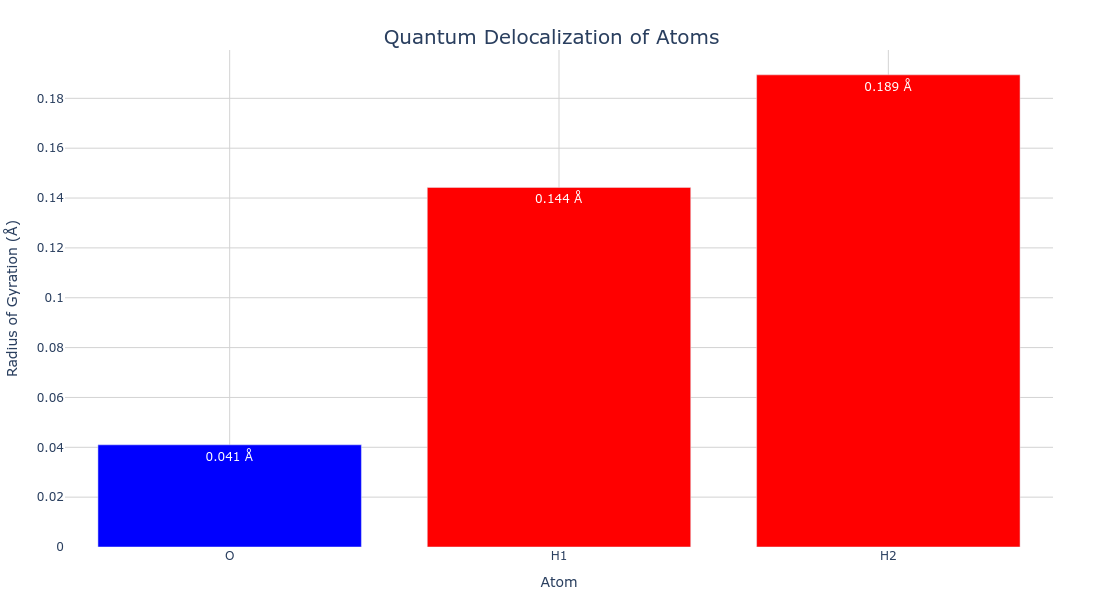


Quantum Delocalization Analysis:
------------------------------
Oxygen (m=16 amu):     0.041 Å
Hydrogen 1 (m=1 amu):  0.144 Å
Hydrogen 2 (m=1 amu):  0.189 Å


In [10]:
def calculate_radius_of_gyration(positions):
    """Calculate radius of gyration for quantum delocalization analysis"""
    centroid = np.mean(positions, axis=0)
    rg = np.sqrt(np.mean(np.sum((positions - centroid)**2, axis=2), axis=0))
    return rg

# Calculate Rg for last frame
frame_idx = -1
all_bead_positions = np.array([traj[frame_idx] for traj in trajectories])
rg = calculate_radius_of_gyration(all_bead_positions)

# Create visualization
fig = go.Figure(go.Bar(
    x=['O', 'H1', 'H2'],
    y=rg,
    text=[f'{val:.3f} Å' for val in rg],
    textposition='auto',
    marker_color=['blue', 'red', 'red'],
    hovertemplate='Atom: %{x}<br>Radius of Gyration: %{y:.3f} Å<extra></extra>'
))

# Configure plot
fig.update_layout(
    plotly_layout,
    title={
        'text': 'Quantum Delocalization of Atoms',
        'font': {'size': 20},
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Atom',
    yaxis_title='Radius of Gyration (Å)',
    showlegend=False,
    annotations=[{
        'text': 'Larger radius of gyration indicates stronger quantum effects',
        'showarrow': False,
        'x': 0.5,
        'y': -0.25,
        'xref': 'paper',
        'yref': 'paper',
        'font': {'size': 12}
    }]
)
fig.show()

# Print analysis
print("\nQuantum Delocalization Analysis:")
print("-" * 30)
print(f"Oxygen (m=16 amu):     {rg[0]:.3f} Å")
print(f"Hydrogen 1 (m=1 amu):  {rg[1]:.3f} Å")
print(f"Hydrogen 2 (m=1 amu):  {rg[2]:.3f} Å")

## 3. Bond Length Analysis

Both classical MD and PIMD show distributions of bond lengths, but for different physical reasons:

### Classical MD Distribution:
- Thermal fluctuations cause bonds to vibrate
- Distribution width increases with temperature
- Symmetric distribution around equilibrium length
- Bond vibrations follow classical mechanics

### PIMD Additional Features:
- Each atom is represented by P beads (ring polymer)
- Distribution includes both:
  1. Thermal fluctuations (as in classical MD)
  2. Quantum zero-point motion and tunneling effects
- Generally wider distribution than classical MD
- Often shows asymmetry due to anharmonicity

### Calculation Method:
1. For each frame in the trajectory:
   - Calculate O-H distances for all P beads
   - This gives P×2 distances (2 hydrogens) per frame
2. Combine all distances into one distribution:
   - All frames
   - All beads
   - Both O-H bonds

### Mathematical Expression:
For frame $t$, bead $i$, the O-H bond length is:

$r_{OH}^{(i,t)} = ||\mathbf{r}_H^{(i,t)} - \mathbf{r}_O^{(i,t)}||$

Total number of bond lengths = (number of frames) × (number of beads) × 2

The following cell performs this analysis and plots the resulting distribution.

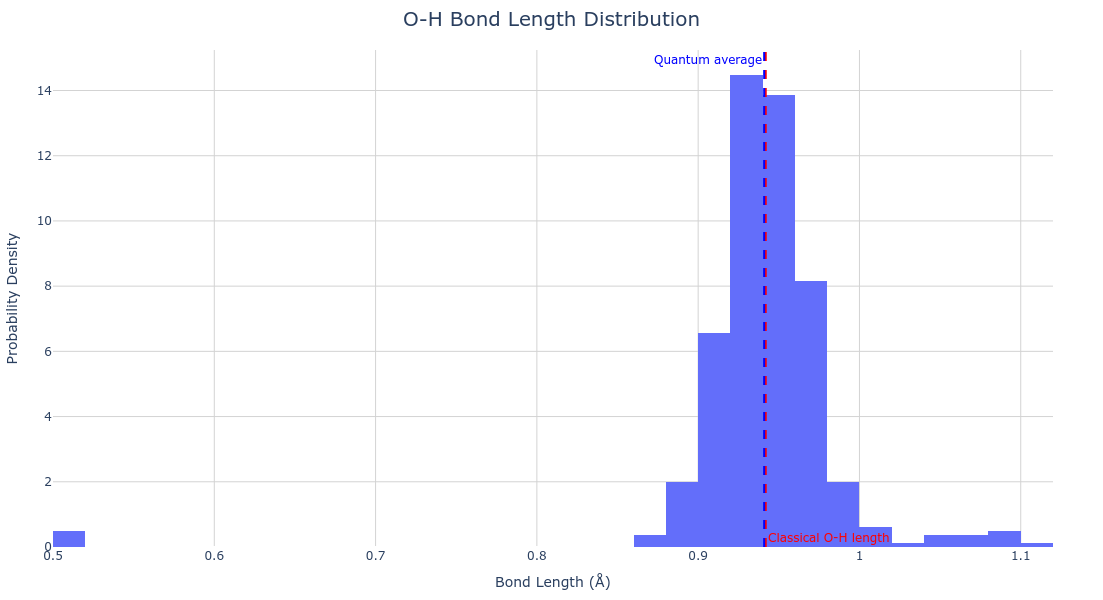


Quantum Effects on O-H Bond:
------------------------------
Classical length:     0.9419 Å
Quantum average:      0.9409 Å
Quantum elongation:   -0.0010 Å  (-0.1%)
Distribution width:   ±0.1092 Å  (95% confidence)


In [11]:
def calculate_bond_lengths(positions):
    """Calculate O-H bond lengths in water molecule"""
    oh1 = np.linalg.norm(positions[:, 1] - positions[:, 0], axis=1)
    oh2 = np.linalg.norm(positions[:, 2] - positions[:, 0], axis=1)
    return oh1, oh2

# Calculate all O-H bond lengths
all_oh1, all_oh2 = [], []
for traj in trajectories:
    oh1, oh2 = calculate_bond_lengths(traj)
    all_oh1.extend(oh1)
    all_oh2.extend(oh2)
all_bonds = all_oh1 + all_oh2

# Create distribution plot
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=all_bonds,
        nbinsx=50,
        name='O-H bonds',
        histnorm='probability density',
        hovertemplate='Bond Length: %{x:.3f} Å<br>Density: %{y:.3f}<extra></extra>'
    )
)

# Add reference lines
classical_length = 0.9419
mean_length = np.mean(all_bonds)
fig.add_vline(x=classical_length, line_dash="dash", line_color="red",
              annotation_text="Classical O-H length", annotation_position="bottom right",
              annotation=dict(font=dict(color="red")))
fig.add_vline(x=mean_length, line_dash="dash", line_color="blue",
              annotation_text="Quantum average", annotation_position="top left",
              annotation=dict(font=dict(color="blue")))

# Configure plot
fig.update_layout(
    plotly_layout,
    title={
        'text': 'O-H Bond Length Distribution',
        'font': {'size': 20},
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Bond Length (Å)',
    yaxis_title='Probability Density'
)
fig.show()

# Analyze quantum effects
std_length = np.std(all_bonds)
elongation = mean_length - classical_length
print("\nQuantum Effects on O-H Bond:")
print("-" * 30)
print(f"Classical length:     {classical_length:.4f} Å")
print(f"Quantum average:      {mean_length:.4f} Å")
print(f"Quantum elongation:   {elongation:.4f} Å  ({(elongation/classical_length)*100:.1f}%)")
print(f"Distribution width:   ±{2*std_length:.4f} Å  (95% confidence)")

## 4. H-O-H Angle Analysis

The H-O-H angle in water molecules exhibits fluctuations due to both thermal and quantum effects. Understanding these fluctuations is crucial as they influence water's properties, particularly hydrogen bonding.

### Classical vs Quantum Angle Distribution:

1. **Classical Fluctuations**:
   - Thermal vibrations around equilibrium angle (107.4° for q-TIP4P/f)
   - Bending mode energy = $\frac{1}{2}k_θ(θ - θ_0)^2$
   - Symmetric distribution at thermal equilibrium

2. **Additional Quantum Effects**:
   - Zero-point angular motion
   - Coupling between bending and stretching modes
   - All P beads contribute to the distribution

### Angle Calculation Method:
For each frame ($t$) and bead ($i$), we calculate:

1. **O-H Vectors**:
   $\mathbf{v}_1^{(i,t)} = \mathbf{r}_{H1}^{(i,t)} - \mathbf{r}_O^{(i,t)}$
   $\mathbf{v}_2^{(i,t)} = \mathbf{r}_{H2}^{(i,t)} - \mathbf{r}_O^{(i,t)}$

2. **Angle via Dot Product**:
   $\theta^{(i,t)} = \arccos\left(\frac{\mathbf{v}_1^{(i,t)} \cdot \mathbf{v}_2^{(i,t)}}{|\mathbf{v}_1^{(i,t)}||\mathbf{v}_2^{(i,t)}|}\right)$

The distribution combines angles from:
- All frames in trajectory
- All beads in the ring polymer
- Total samples = (number of frames) × (number of beads)

The following cell analyzes the H-O-H angle distribution and compares it with the classical equilibrium value.

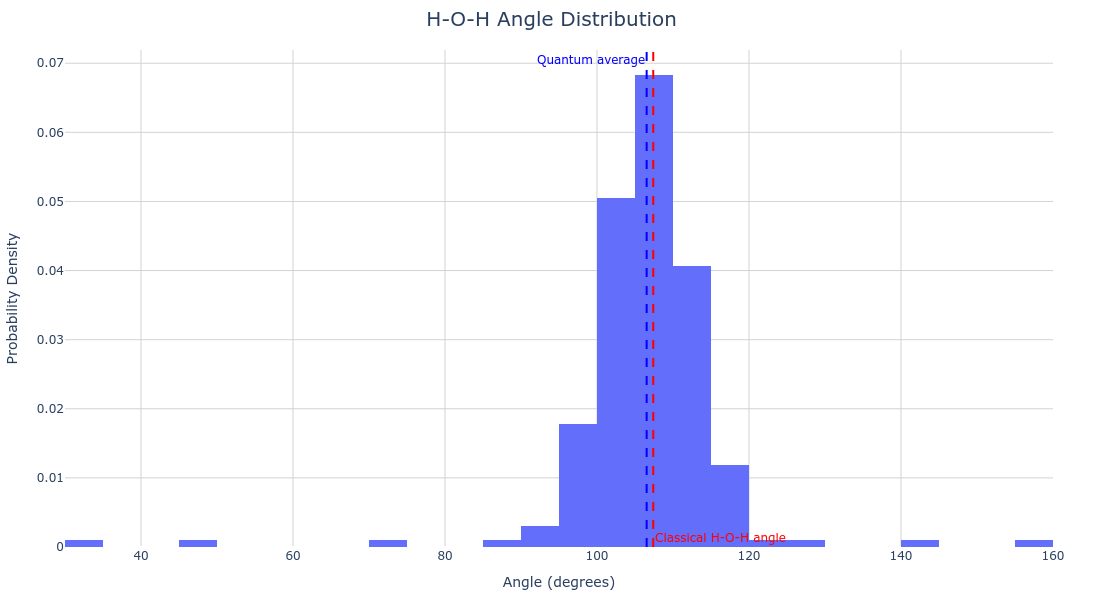

H-O-H Angle Analysis:
-------------------------
Classical angle:  107.4°
Quantum average:  106.5°
Quantum shift:    -0.9°  (-0.8%)
Fluctuations:     ±20.1°  (95% interval)


In [12]:
def calculate_angle(positions):
    """Calculate H-O-H angle using dot product method"""
    # Get O-H vectors
    v1 = positions[:, 1] - positions[:, 0]  # O to H1
    v2 = positions[:, 2] - positions[:, 0]  # O to H2
    
    # Normalize vectors
    v1_norm = v1 / np.linalg.norm(v1, axis=1)[:, np.newaxis]
    v2_norm = v2 / np.linalg.norm(v2, axis=1)[:, np.newaxis]
    
    # Calculate angle (degrees)
    cos_angle = np.sum(v1_norm * v2_norm, axis=1)
    angles = np.arccos(np.clip(cos_angle, -1.0, 1.0)) * 180/np.pi
    return angles

# Calculate angles for all beads and frames
all_angles = []
for traj in trajectories:
    angles = calculate_angle(traj)
    all_angles.extend(angles)

# Create angle distribution plot
fig = go.Figure()

# Add histogram
fig.add_trace(
    go.Histogram(
        x=all_angles,
        nbinsx=50,
        histnorm='probability density',
        hovertemplate='Angle: %{x:.2f}°<br>Density: %{y:.3f}<extra></extra>'
    )
)

# Add reference angles
classical_angle = 107.4
mean_angle = np.mean(all_angles)

# Classical reference
fig.add_vline(
    x=classical_angle,
    line_dash="dash",
    line_color="red",
    annotation_text="Classical H-O-H angle",
    annotation_position="bottom right",
    annotation=dict(font=dict(color="red"))
)

# Quantum average
fig.add_vline(
    x=mean_angle,
    line_dash="dash",
    line_color="blue",
    annotation_text="Quantum average",
    annotation_position="top left",
    annotation=dict(font=dict(color="blue"))
)

# Configure plot
fig.update_layout(
    plotly_layout,
    title={
        'text': 'H-O-H Angle Distribution',
        'font': {'size': 20},
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Angle (degrees)',
    yaxis_title='Probability Density'
)
fig.show()

# Analyze quantum effects
std_angle = np.std(all_angles)
angle_shift = mean_angle - classical_angle

print("H-O-H Angle Analysis:")
print("-" * 25)
print(f"Classical angle:  {classical_angle:.1f}°")
print(f"Quantum average:  {mean_angle:.1f}°")
print(f"Quantum shift:    {angle_shift:+.1f}°  ({angle_shift/classical_angle*100:+.1f}%)")
print(f"Fluctuations:     ±{2*std_angle:.1f}°  (95% interval)")

## 5. Visualizing Ring Polymer

The ring polymer representation is at the heart of Path Integral MD, providing a way to visualize quantum delocalization of atoms. Here we'll create interactive 3D visualizations of the ring polymers for both oxygen and hydrogen atoms.

### Ring Polymer Structure:
1. **Beads**: 
   - Each bead represents a different configuration
   - Total of P beads form the ring polymer
   - Connected by harmonic springs with frequency ω = P/(βℏ)
   - β = 1/(kT) is inverse temperature

2. **Centroid**:
   - Average position of all beads
   - $\mathbf{r}_c = \frac{1}{P}\sum_{i=1}^P \mathbf{r}_i$
   - Corresponds to classical position
   - Marked in red in visualization

3. **Spread**:
   - Distance of beads from centroid
   - Larger for lighter atoms (H vs O)
   - Reflects quantum uncertainty
   - Maximum spread = largest bead-centroid distance

### Visualization Features:
- Blue points: O atom beads
- Red points: H atom beads
- Diamond marker: Centroid position
- Semi-transparent lines: Spring connections
- Interactive controls for rotation and zoom

The following cell creates 3D visualizations of both O and H ring polymers from the last frame of our simulation.

In [7]:
def plot_ring_polymer(positions, atom_idx, title, color='blue'):
    """Create interactive 3D visualization of ring polymer"""
    # Get atomic positions and centroid
    x = positions[:, atom_idx, 0]
    y = positions[:, atom_idx, 1]
    z = positions[:, atom_idx, 2]
    centroid = np.mean(positions[:, atom_idx], axis=0)
    
    # Create figure
    fig = go.Figure()
    
    # Plot beads
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=6, color=color, opacity=0.8),
        name='Beads',
        hovertemplate='x: %{x:.3f}<br>y: %{y:.3f}<br>z: %{z:.3f}<extra>Bead</extra>'
    ))
    
    # Add connections
    transparent_color = f'rgba{tuple(int(x) for x in plt.cm.colors.to_rgb(color)) + (0.3,)}'
    for i in range(len(x)):
        j = (i + 1) % len(x)
        fig.add_trace(go.Scatter3d(
            x=[x[i], x[j]], y=[y[i], y[j]], z=[z[i], z[j]],
            mode='lines',
            line=dict(color=transparent_color, width=2),
            showlegend=False,
            hoverinfo='skip'
        ))
    
    # Add centroid
    fig.add_trace(go.Scatter3d(
        x=[centroid[0]], y=[centroid[1]], z=[centroid[2]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='diamond'),
        name='Centroid',
        hovertemplate='x: %{x:.3f}<br>y: %{y:.3f}<br>z: %{z:.3f}<extra>Centroid</extra>'
    ))
    
    # Configure layout
    fig.update_layout(
        plotly_layout_3d,
        title={
        'text': f'{title}<br><sup>Interactive 3D Visualization</sup>',
        'font': {'size': 20},
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
        scene=dict(
            xaxis_title='X (Å)',
            yaxis_title='Y (Å)',
            zaxis_title='Z (Å)',
            aspectmode='cube'
        ),
        annotations=[{
            'text': 'Drag to rotate | Scroll to zoom | Double-click to reset view',
            'showarrow': False,
            'x': 0.5,
            'y': -0.08,
            'xref': 'paper',
            'yref': 'paper',
            'font': {'size': 12}
        }]
    )
    return fig

# Create visualizations
print("Visualizing ring polymers (interactive 3D plots):")

# Oxygen polymer (blue)
fig_o = plot_ring_polymer(all_bead_positions, 0, 'Oxygen Ring Polymer', 'blue')
fig_o.show()

# Hydrogen polymer (red)
fig_h = plot_ring_polymer(all_bead_positions, 1, 'Hydrogen Ring Polymer', 'red')
fig_h.show()

# Print analysis
for idx, atom in enumerate(['Oxygen', 'Hydrogen']):
    centroid = np.mean(all_bead_positions[:, idx], axis=0)
    max_spread = np.max(np.linalg.norm(all_bead_positions[:, idx] - centroid, axis=1))
    
    print(f"\n{atom} Ring Polymer Properties:")
    print(f"Beads:            {len(all_bead_positions)}")
    print(f"Maximum spread:   {max_spread:.3f} Å")
    print(f"Centroid (x,y,z): ({centroid[0]:.3f}, {centroid[1]:.3f}, {centroid[2]:.3f}) Å")

Visualizing ring polymers (interactive 3D plots):


NameError: name 'plt' is not defined

## Discussion Questions

1. Why is the radius of gyration different for oxygen and hydrogen atoms? What does this tell us about quantum effects?

2. How does the average O-H bond length compare to the classical value? Why is there a distribution rather than a single value?

3. What does the width of the H-O-H angle distribution tell us about the quantum nature of water?

4. Looking at the ring polymer visualizations, why do hydrogen atoms show more spread than oxygen?